In [2]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

# Multilayer perceptron

In [3]:
data_root_dir = "/home/jinhyun/data"

train_dataset = datasets.MNIST(
    root=data_root_dir,
    train=True,
    download=True,
    transform=ToTensor(),
)

test_dataset = datasets.MNIST(
    root=data_root_dir,
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
print("Train size: ", len(train_dataset))
print("Test size: ", len(test_dataset))
print("Image size: ", train_dataset[0][0].shape)

Train size:  60000
Test size:  10000
Image size:  torch.Size([1, 28, 28])


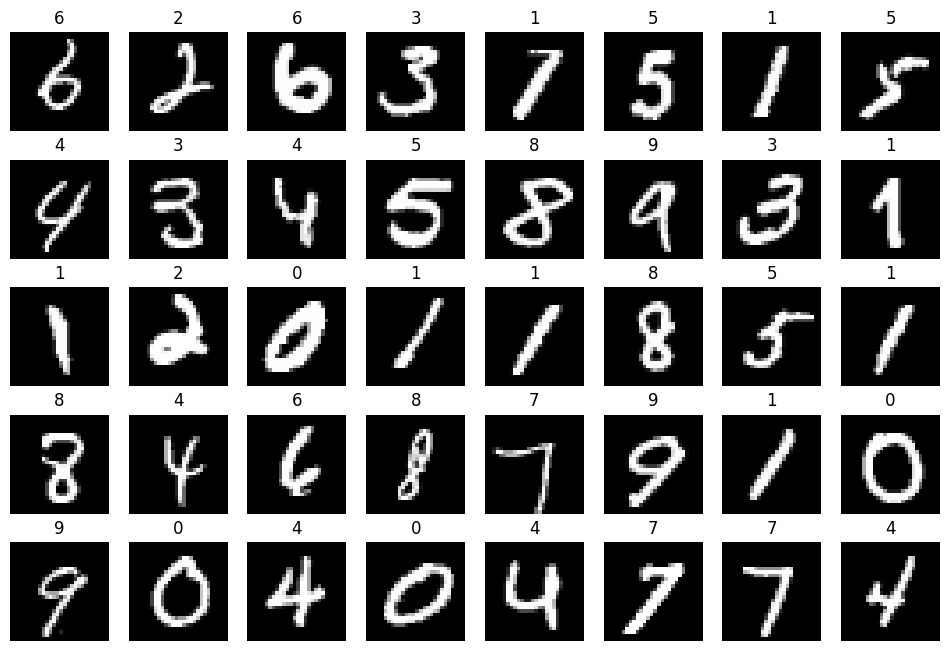

In [5]:

figure = plt.figure(figsize=(12, 8))
cols, rows = 8, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [7]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class MultiLayerPerceptron(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits



Using cuda device


In [8]:
in_dim, hidden_dim, out_dim = 28*28, 512, 10
model = MultiLayerPerceptron(in_dim, hidden_dim, out_dim).to(device)

In [9]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Params : {param[:2]} \n")

Model structure: MultiLayerPerceptron(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Params : tensor([[ 0.0147, -0.0106, -0.0130,  ..., -0.0146, -0.0286,  0.0002],
        [-0.0190, -0.0015,  0.0064,  ..., -0.0158,  0.0291,  0.0120]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Params : tensor([0.0133, 0.0292], device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Params : tensor([[-0.0355,  0.0396, -0.0046,  ...,  0.0172,  0.0327, -0.0170],
        [-0.0157, -0.0383,  0.0019,  ..., -0.0230, -0.0342, -0.0140]],
       device='cuda:0', grad_f

In [10]:
X = torch.randn((batch_size, in_dim)).to(device)
logits = model(X) #forward pass
print(logits.shape)

torch.Size([64, 10])


In [11]:
for p in model.parameters():
    print(p.shape, p.grad)

torch.Size([512, 784]) None
torch.Size([512]) None
torch.Size([512, 512]) None
torch.Size([512]) None
torch.Size([10, 512]) None
torch.Size([10]) None


In [12]:
y = torch.randint(10, (batch_size,)).to(device)
loss = nn.CrossEntropyLoss()(logits, y)
loss.backward()

In [13]:
for p in model.parameters():
    print(p.shape, p.grad.shape)

torch.Size([512, 784]) torch.Size([512, 784])
torch.Size([512]) torch.Size([512])
torch.Size([512, 512]) torch.Size([512, 512])
torch.Size([512]) torch.Size([512])
torch.Size([10, 512]) torch.Size([10, 512])
torch.Size([10]) torch.Size([10])


In [14]:
learning_rate = 1e-3
model = MultiLayerPerceptron(in_dim, hidden_dim, out_dim).to(device)
loss_fn = nn.CrossEntropyLoss() # combines nn.LogSoftmax and nn.NLLLoss.
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [15]:
def train_loop(train_loader, model, loss_fn, optimizer):
    size = len(train_loader.dataset)
    model.train() #Switch to train mode

    running_loss = 0.0
    for batch_idx, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)

        logits = model(X) 
        loss = loss_fn(logits, y)

        loss.backward() # Backpropagation. grads are saved inside each model parameters
        optimizer.step() # update parameters by the gradients
        optimizer.zero_grad() # reset the gradients of model parameters

        running_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f"Train loss: {loss.item():>7f}  [{(batch_idx + 1) * len(X):>5d}/{size:>5d}]")

    return(running_loss/len(train_loader))

In [16]:
def test_loop(dataloader, model, loss_fn):
    model.eval() # Set the model to evaluation mode. important for batch normalization and dropout layers

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0.0, 0.0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            pred_probab = nn.Softmax(dim=1)(logits)
            y_pred = logits.argmax(dim = 1)

            test_loss += loss_fn(logits, y).item()
            correct += (y_pred == y).type(torch.float).sum().item()

    avg_test_loss = test_loss / num_batches
    accuracy = correct / size
    print(f"Test \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {avg_test_loss:>8f} \n")

In [17]:
epochs = 40

train_loss_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    train_loss_list.append(train_loss)
    test_loop(test_dataloader, model, loss_fn)


Epoch 1
-------------------------------
Train loss: 2.309705  [   64/60000]
Train loss: 2.292254  [ 6464/60000]
Train loss: 2.293155  [12864/60000]
Train loss: 2.287972  [19264/60000]
Train loss: 2.283774  [25664/60000]
Train loss: 2.270946  [32064/60000]
Train loss: 2.274633  [38464/60000]
Train loss: 2.269135  [44864/60000]
Train loss: 2.264608  [51264/60000]
Train loss: 2.254564  [57664/60000]
Test 
 Accuracy: 51.4%, Avg loss: 2.251644 

Epoch 2
-------------------------------
Train loss: 2.250763  [   64/60000]
Train loss: 2.248065  [ 6464/60000]
Train loss: 2.244992  [12864/60000]
Train loss: 2.254749  [19264/60000]
Train loss: 2.227546  [25664/60000]
Train loss: 2.231848  [32064/60000]
Train loss: 2.219595  [38464/60000]
Train loss: 2.197874  [44864/60000]
Train loss: 2.186048  [51264/60000]
Train loss: 2.186357  [57664/60000]
Test 
 Accuracy: 60.4%, Avg loss: 2.179517 

Epoch 3
-------------------------------
Train loss: 2.147256  [   64/60000]
Train loss: 2.172380  [ 6464/60000

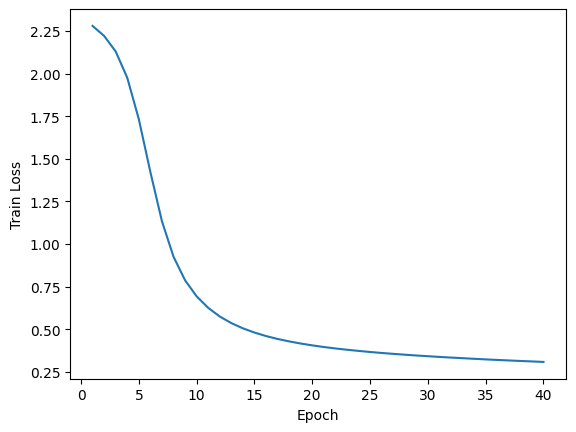

In [18]:
plt.plot([i for i in range(1,epochs+1)], train_loss_list)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')

plt.show ()

In [10]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [11]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [12]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
